In [1]:
import pandas as pd
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Hinged Square Loss
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=1):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, predicted, y):
        low, high = y[:, 0:1], y[:, 1:2]
        loss_low = torch.relu(low - predicted + self.margin)
        loss_high = torch.relu(predicted - high + self.margin)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss))

In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 1, bias=True)   # XB1 + B0 (bias)
        self.linear2 = nn.Linear(input_size, 1, bias=False)  # XB2
        self.relu = nn.ReLU()  # Instantiate ReLU

    def forward(self, X):
        linear_part1 = self.linear1(X)  # XB1 + B0 (bias)
        linear_part2 = self.linear2(X)  # XB2
        y = linear_part1 + self.relu(linear_part2)  # Apply ReLU to linear_part2
        return y

In [4]:
class ModelTrainer:
    def __init__(self, dataset, chosen_feature, test_fold):
        self.dataset = dataset
        self.chosen_feature = chosen_feature
        self.test_fold = test_fold
        self.SimpleNN = SimpleNN
        self.load_data()
        self.prepare_data()
        self.initialize_model()

    def load_data(self):
        self.folds_df = pd.read_csv(f'../../training_data/{self.dataset}/folds.csv')
        self.features_df = pd.read_csv(f'../../training_data/{self.dataset}/features.csv')[['sequenceID'] + self.chosen_feature]
        self.target_df = pd.read_csv(f'../../training_data/{self.dataset}/target.csv')
    
    def prepare_data(self):
        train_ids = self.folds_df[self.folds_df['fold'] != self.test_fold]['sequenceID']
        test_ids = self.folds_df[self.folds_df['fold'] == self.test_fold]['sequenceID']

        self.features_df_train = self.features_df[self.features_df['sequenceID'].isin(train_ids)]
        self.features_df_test = self.features_df[self.features_df['sequenceID'].isin(test_ids)]
        self.target_df_train = self.target_df[self.target_df['sequenceID'].isin(train_ids)]
        self.target_df_test = self.target_df[self.target_df['sequenceID'].isin(test_ids)]

        self.X_train = self.features_df_train[self.chosen_feature].to_numpy()
        self.y_train = self.target_df_train.iloc[:, 1:].to_numpy()
        self.X_test = self.features_df_test[self.chosen_feature].to_numpy()
        self.y_test = self.target_df_test.iloc[:, 1:].to_numpy()

        self.X_train_tensor = torch.tensor(self.X_train, dtype=torch.float32)
        self.y_train_tensor = torch.tensor(self.y_train, dtype=torch.float32)
        self.X_test_tensor = torch.tensor(self.X_test, dtype=torch.float32)
        self.y_test_tensor = torch.tensor(self.y_test, dtype=torch.float32)


    def initialize_model(self):
        self.input_dim = self.X_train.shape[1]
        self.model = self.SimpleNN(self.input_dim)
        self.criterion = SquaredHingeLoss()
        self.optimizer = optim.Adam(self.model.parameters())

        # Initialize parameters with different random values
        for param in self.model.parameters():
            if param.requires_grad:
                nn.init.normal_(param, mean=0.0, std=100.0)  # Random normal initialization


    def train(self, epochs=1000000, patience=5000, verbose=True):
        best_train_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train()
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(self.X_train_tensor)
            loss = self.criterion(outputs, self.y_train_tensor)

            # Backward pass and optimization
            loss.backward()
            self.optimizer.step()

            # Early stopping check
            train_loss = loss.item()
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                self.best_model = self.model.state_dict()  # Save the best model state
                patience_counter = 0
            else:
                patience_counter += 1

            # Verbose output to track progress
            if verbose and epoch % 5000 == 0:  # Print every 5000 epochs
                print(f"Epoch [{epoch}/{epochs}] - Loss: {train_loss:.6f}, Best Loss: {best_train_loss:.6f}")

            # Check if patience is exceeded
            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch}. Best Loss: {best_train_loss:.6f}")
                break

        # Load the best model after training
        self.model.load_state_dict(self.best_model)
        if verbose:
            print("Training complete.")


    def predict(self):
        self.model.eval()
        self.y_pred = self.model(self.X_test_tensor).detach().numpy().ravel()

    def plot_results(self):
        x = self.X_test_tensor.numpy()
        y_low = self.y_test_tensor.numpy()[:, 0]
        y_high = self.y_test_tensor.numpy()[:, 1]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Scatter plot for x vs y_low and x vs y_high
        ax.scatter(x, y_low, color='blue', edgecolor='black', marker='o', label='y_low', facecolors='none', s=15)
        ax.scatter(x, y_high, color='red', marker='o', label='y_high', s=15)

        # Draw vertical lines from y_low to y_high
        for xi, yi_low, yi_high in zip(x, y_low, y_high):
            ax.plot([xi, xi], [yi_low, yi_high], color='gray', linestyle='--')

        # Draw piecewise line for x vs y_pred
        x_model = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        y_model = self.model(torch.tensor(x_model, dtype=torch.float32)).detach().numpy().ravel()
        ax.plot(x_model, y_model, color='black', label='y_pred', linestyle='-', linewidth=1)

        # Add labels and legend
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()

        # Calculate the loss for the test set
        y_pred_test = self.model(self.X_test_tensor)
        test_loss = self.criterion(y_pred_test, self.y_test_tensor).item()

        # Display the loss in the bottom-right corner of the plot
        ax.text(0.95, 0.05, f'Loss: {test_loss:.4f}', transform=ax.transAxes, 
                fontsize=12, verticalalignment='bottom', horizontalalignment='right', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        # Show the plot
        plt.show()

Trial number 1
Epoch [0/1000000] - Loss: 65159.175781, Best Loss: 65159.175781
Epoch [5000/1000000] - Loss: 61431.562500, Best Loss: 61431.562500
Epoch [10000/1000000] - Loss: 57865.128906, Best Loss: 57865.128906
Epoch [15000/1000000] - Loss: 54455.351562, Best Loss: 54455.351562
Epoch [20000/1000000] - Loss: 51201.488281, Best Loss: 51201.488281
Epoch [25000/1000000] - Loss: 48104.132812, Best Loss: 48104.132812
Epoch [30000/1000000] - Loss: 45178.269531, Best Loss: 45178.269531
Epoch [35000/1000000] - Loss: 42419.890625, Best Loss: 42419.890625
Epoch [40000/1000000] - Loss: 39815.378906, Best Loss: 39815.378906
Epoch [45000/1000000] - Loss: 37363.851562, Best Loss: 37363.851562
Epoch [50000/1000000] - Loss: 35064.167969, Best Loss: 35064.167969
Epoch [55000/1000000] - Loss: 32915.812500, Best Loss: 32915.812500
Epoch [60000/1000000] - Loss: 30915.527344, Best Loss: 30915.527344
Epoch [65000/1000000] - Loss: 29060.398438, Best Loss: 29060.398438
Epoch [70000/1000000] - Loss: 27314.11

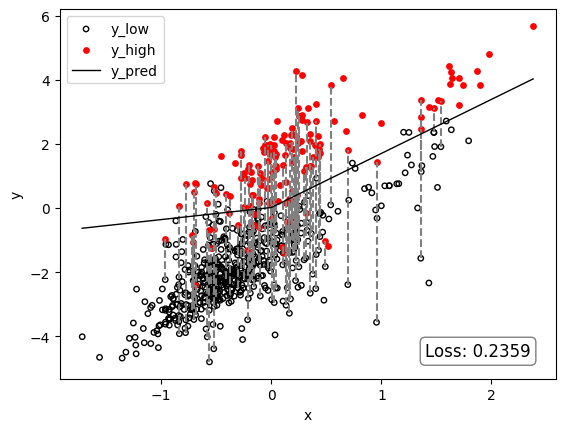

Trial number 2
Epoch [0/1000000] - Loss: 2194.229004, Best Loss: 2194.229004
Epoch [5000/1000000] - Loss: 1928.210938, Best Loss: 1928.210938
Epoch [10000/1000000] - Loss: 1681.185303, Best Loss: 1681.185303
Epoch [15000/1000000] - Loss: 1451.280396, Best Loss: 1451.280396
Epoch [20000/1000000] - Loss: 1238.447510, Best Loss: 1238.447510
Epoch [25000/1000000] - Loss: 1042.702637, Best Loss: 1042.702637
Epoch [30000/1000000] - Loss: 864.541077, Best Loss: 864.541077
Epoch [35000/1000000] - Loss: 721.310181, Best Loss: 721.310181
Epoch [40000/1000000] - Loss: 593.747314, Best Loss: 593.747314
Epoch [45000/1000000] - Loss: 481.232452, Best Loss: 481.232452
Epoch [50000/1000000] - Loss: 380.974457, Best Loss: 380.974457
Epoch [55000/1000000] - Loss: 292.662567, Best Loss: 292.662567
Epoch [60000/1000000] - Loss: 216.238815, Best Loss: 216.238815
Epoch [65000/1000000] - Loss: 151.702759, Best Loss: 151.702759
Epoch [70000/1000000] - Loss: 98.948097, Best Loss: 98.948097
Epoch [75000/1000000

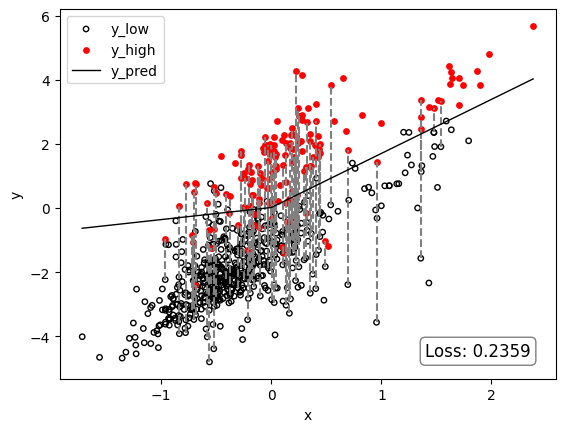

Trial number 3
Epoch [0/1000000] - Loss: 2241.682861, Best Loss: 2241.682861
Epoch [5000/1000000] - Loss: 1973.103271, Best Loss: 1973.103271
Epoch [10000/1000000] - Loss: 1723.308350, Best Loss: 1723.308350
Epoch [15000/1000000] - Loss: 1490.852051, Best Loss: 1490.852051
Epoch [20000/1000000] - Loss: 1275.494263, Best Loss: 1275.494263
Epoch [25000/1000000] - Loss: 1077.707642, Best Loss: 1077.707642
Epoch [30000/1000000] - Loss: 896.953247, Best Loss: 896.953247
Epoch [35000/1000000] - Loss: 733.449097, Best Loss: 733.449097
Epoch [40000/1000000] - Loss: 587.312134, Best Loss: 587.312134
Epoch [45000/1000000] - Loss: 458.252411, Best Loss: 458.252411
Epoch [50000/1000000] - Loss: 346.213989, Best Loss: 346.213989
Epoch [55000/1000000] - Loss: 251.262573, Best Loss: 251.262573
Epoch [60000/1000000] - Loss: 173.148071, Best Loss: 173.148071
Epoch [65000/1000000] - Loss: 111.709366, Best Loss: 111.709366
Epoch [70000/1000000] - Loss: 66.512047, Best Loss: 66.512047
Epoch [75000/1000000

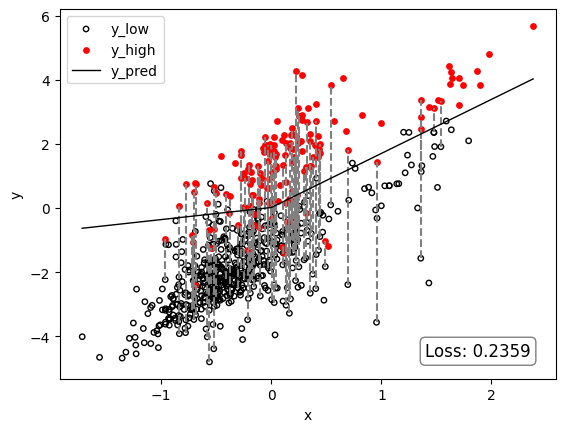

Trial number 4
Epoch [0/1000000] - Loss: 9029.936523, Best Loss: 9029.936523
Epoch [5000/1000000] - Loss: 7882.123535, Best Loss: 7882.123535
Epoch [10000/1000000] - Loss: 6829.766602, Best Loss: 6829.766602
Epoch [15000/1000000] - Loss: 5865.714844, Best Loss: 5865.714844
Epoch [20000/1000000] - Loss: 4990.111816, Best Loss: 4990.111816
Epoch [25000/1000000] - Loss: 4205.172363, Best Loss: 4205.172363
Epoch [30000/1000000] - Loss: 3508.815430, Best Loss: 3508.815430
Epoch [35000/1000000] - Loss: 2897.843262, Best Loss: 2897.843262
Epoch [40000/1000000] - Loss: 2369.942383, Best Loss: 2369.942383
Epoch [45000/1000000] - Loss: 1921.789551, Best Loss: 1921.789551
Epoch [50000/1000000] - Loss: 1544.330933, Best Loss: 1544.330933
Epoch [55000/1000000] - Loss: 1231.207275, Best Loss: 1231.207275
Epoch [60000/1000000] - Loss: 975.416992, Best Loss: 975.416992
Epoch [65000/1000000] - Loss: 765.972168, Best Loss: 765.972168
Epoch [70000/1000000] - Loss: 597.167786, Best Loss: 597.167786
Epoch 

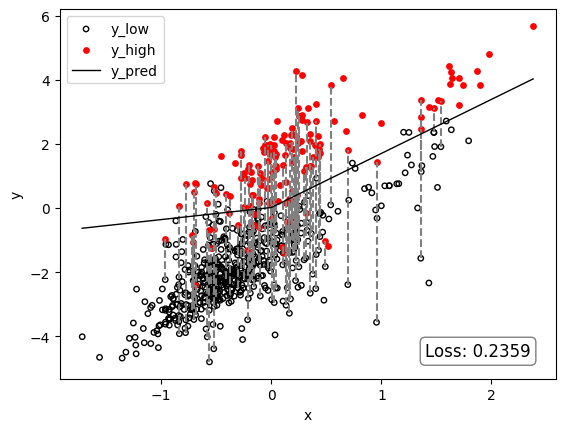

Trial number 5
Epoch [0/1000000] - Loss: 51550.449219, Best Loss: 51550.449219
Epoch [5000/1000000] - Loss: 48596.406250, Best Loss: 48596.406250
Epoch [10000/1000000] - Loss: 45735.152344, Best Loss: 45735.152344
Epoch [15000/1000000] - Loss: 42964.242188, Best Loss: 42964.242188
Epoch [20000/1000000] - Loss: 40283.929688, Best Loss: 40283.929688
Epoch [25000/1000000] - Loss: 37693.136719, Best Loss: 37693.136719
Epoch [30000/1000000] - Loss: 35192.355469, Best Loss: 35192.355469
Epoch [35000/1000000] - Loss: 32781.339844, Best Loss: 32781.339844
Epoch [40000/1000000] - Loss: 30460.171875, Best Loss: 30460.171875
Epoch [45000/1000000] - Loss: 28228.906250, Best Loss: 28228.906250
Epoch [50000/1000000] - Loss: 26087.425781, Best Loss: 26087.425781
Epoch [55000/1000000] - Loss: 24035.871094, Best Loss: 24035.871094
Epoch [60000/1000000] - Loss: 22073.916016, Best Loss: 22073.916016
Epoch [65000/1000000] - Loss: 20202.039062, Best Loss: 20202.039062
Epoch [70000/1000000] - Loss: 18419.97

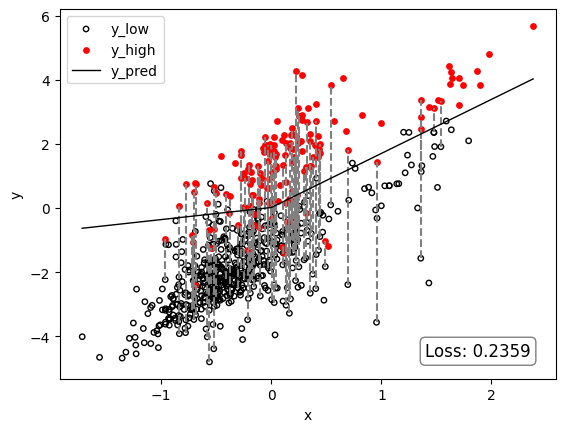

In [5]:
for i in range(5):
    print(f"Trial number {i+1}")

    trainer = ModelTrainer(
        dataset='detailed',
        chosen_feature=['log_range_value'],
        test_fold=1
    )

    # Re-initialize parameters for each trial with different values
    trainer.initialize_model()
    trainer.train()
    trainer.predict()
    trainer.plot_results()